<a href="https://colab.research.google.com/github/OceanManDiani/OceanManDiani/blob/main/Hybrid_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [3]:
import pandas as pd
from scipy import stats 
from datetime import timedelta
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from xgboost import plot_importance, plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import yfinance as yf
import numpy as np
import joblib
import os
import tensorflow as tf
import warnings
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from xgboost import plot_importance
#ParameterGrid for Gridsearch without CV


from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVR


warnings.filterwarnings("ignore")

## UDFs

In [4]:
def window_optimization(plots):
    
    """Returns the key that contains the most optimal window (respect to mae) for t+1"""
    
    assert type(plots) == dict, "plots musst be a dictionary"
    
    rank = []
    m = []
    for i in plots.keys():
        if not rank:
            rank.append(plots[i])
            m.append(i)
        elif plots[i][3]<rank[0][3]:
            rank.clear()
            m.clear()
            rank.append(plots[i])
            m.append(i)
            
    return rank, m

In [5]:
def predictions(mae_lstm, mae_xgboost, prediction_xgb, prediction_lstm):
    
    """Returns the prediction at t+1 weighted by the respective mae. Giving a higher weight to the one which is lower"""
    
    prediction = (1-(mae_xgboost/(mae_lstm+mae_xgboost)))*prediction_xgb+(1-(mae_lstm/(mae_lstm+mae_xgboost)))*prediction_lstm
    return prediction

In [6]:
def plotting(y_val, y_test, pred_test, mae, WINDOW, PREDICTION_SCOPE):
    
    """This function returns a graph where:
        - Validation Set
        - Test Set
        - Future Prediction
        - Upper Bound
        - Lower Bound
    """
    assert type(WINDOW) == int, "Window musst be an integer"
    assert type(PREDICTION_SCOPE) == int, "Preiction scope musst be an integer"
    
    ploting_pred = [y_test[-1], pred_test]
    ploting_test = [y_val[-1]]+list(y_test)

    time = (len(y_val)-1)+(len(ploting_test)-1)+(len(ploting_pred)-1)

    test_time_init = time-(len(ploting_test)-1)-(len(ploting_pred)-1)
    test_time_end = time-(len(ploting_pred)-1)+1

    pred_time_init = time-(len(ploting_pred)-1)
    pred_time_end = time+1

    x_ticks = list(stock_prices.index[-time:])+[stock_prices.index[-1]+timedelta(PREDICTION_SCOPE+1)]

    values_for_bounds = list(y_val)+list(y_test)+list(pred_test)
    upper_band = values_for_bounds+mae
    lower_band = values_for_bounds-mae
    
    print(f"For used windowed data: {WINDOW}")
    print(f"Prediction scope for date {x_ticks[-1]} / {PREDICTION_SCOPE+1} days")
    print(f"The predicted price is {str(round(ploting_pred[-1][0],2))}$")
    print(f"With a spread of MAE is {round(mae,2)}")
    print()
    
    plt.figure(figsize=(16, 8))

    plt.plot(list(range(test_time_init, test_time_end)),ploting_test, marker="$m$", color="orange")
    plt.plot(list(range(pred_time_init, pred_time_end)),ploting_pred,marker="$m$", color="red")
    plt.plot(y_val, marker="$m$")

    plt.plot(upper_band, color="grey", alpha=.3)
    plt.plot(lower_band, color="grey", alpha=.3)

    plt.fill_between(list(range(0, time+1)),upper_band, lower_band, color="grey", alpha=.1)

    plt.xticks(list(range(0-1, time)), x_ticks, rotation=45)
    plt.text(time-0.5, ploting_pred[-1]+2, str(round(ploting_pred[-1][0],2))+"$", size=11, color='red')
    plt.title(f"Target price for date {x_ticks[-1]} / {PREDICTION_SCOPE+1} days, with used past data of {WINDOW} days and a MAE of {round(mae,2)}", size=15)
    plt.legend(["Testing Set (input for Prediction)", "Prediction", "Validation"])
    plt.show()
    
    print()
    print("-----------------------------------------------------------------------------")
    print()

In [7]:
def sp500_log_rets(tickers):
    
    """Returns the logarithmic returns from the SP500"""
    
    stock_prices = yf.download(tickers, start="2015-11-30", end="2021-11-30")["Close"]
    log_rets = {}
    for index, ticker in enumerate(tickers):
        log_rets[ticker] = np.log(stock_prices[ticker]/stock_prices[ticker].shift(1))
    return log_rets

In [8]:
def annualized_rets(r):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(255/n_periods)-1

In [9]:
def windowing(train, val, WINDOW, PREDICTION_SCOPE):
    
    """Divides the inserted data into a list of lists. Where the shape of the data becomes and additional axe, which is time
    Input:
        - Train Set
        - Validation Set
        - WINDOW: the desired window
        - PREDICTION_SCOPE: The period in the future you want to analyze
    """
    
    assert type(train) == np.ndarray, "train musst be passed as an array"
    assert type(val) == np.ndarray, "validation musst be passed as an array"
    assert type(WINDOW) == int, "Window musst be an integer"
    assert type(PREDICTION_SCOPE) == int, "Preiction scope musst be an integer"
    
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for i in range(len(train)-(WINDOW+PREDICTION_SCOPE)):
        X, y = np.array(train[i:i+WINDOW, :-1]), np.array(train[i+WINDOW+PREDICTION_SCOPE, -1])
        X_train.append(X)
        y_train.append(y)

    for i in range(len(val)-(WINDOW+PREDICTION_SCOPE)):
        X, y = np.array(val[i:i+WINDOW, :-1]), np.array(val[i+WINDOW+PREDICTION_SCOPE, -1])
        X_test.append(X)
        y_test.append(y)
        
    
    return X_train, y_train, X_test, y_test

In [10]:
def feature_engineering(data, SPY, predictions=np.array([None])):
    
    """
    The function applies future engineering to the data in order to get more information out of the inserted data.
    """
    
    assert type(data) == pd.core.frame.DataFrame, "data musst be a dataframe"
    assert type(SPY) == pd.core.series.Series, "SPY musst be a dataframe"
    assert type(predictions) == np.ndarray, "predictions musst be an array"
    
    if predictions.any() ==  True:
        data = yf.download("SPY", start="2001-11-30")
        SPY = yf.download("^VIX", start="2001-11-30")["Close"]
        data = features(data, SPY)
        print(data.shape)
        data["Predictions"] = predictions
        data["Close"] = data["Close_y"]
        data.drop("Close_y",1,  inplace=True)
        data.dropna(0, inplace=True)
    else:
        print("No model yet")
        data = features(data, SPY)
    return data

def features(data, SPY):
    
    for i in [2, 3, 4, 5, 6, 7]:
        data[f"Adj_Close{i}"] = data["Adj Close"].rolling(i).mean()
        data[f"Volume{i}"] = data["Volume"].rolling(i).mean()

        data[f"Low_std{i}"] = data["Low"].rolling(i).std()
        data[f"High_std{i}"] = data["High"].rolling(i).std()
        data[f"Adj_CLose{i}"] = data["Adj Close"].rolling(i).std()

        data[f"Close{i}"] = data["Close"].shift(i)

        data[f"Adj_Close{i}"] = data["Adj Close"].rolling(i).max()
        data[f"Adj_Close{i}"] = data["Adj Close"].rolling(i).min()

        data[f"Adj_Close{i}"] = data["Adj Close"].rolling(i).quantile(1)
    
    
    #FEATURE ENGINEERING
    data["SPY"] = SPY
    data["Day"] = data.index.day
    data["Month"] = data.index.day
    data["Year"] = data.index.day
    data["day_year"] = data.index.day_of_year
    data["Weekday"] = data.index.weekday
    data["Upper_Shape"] = data["High"]-np.maximum(data["Open"], data["Close"])
    data["Lower_Shape"] = np.minimum(data["Open"], data["Close"])-data["Low"]
    data["Close_y"] = data["Close"]
    data.drop("Close",1,  inplace=True)
    data.dropna(0, inplace=True)
    return data

In [11]:
def train_test_split(data, WINDOW):
    """
    Divides the training set into train and validation set depending on the percentage indicated
    """
    assert type(data) == pd.core.frame.DataFrame, "data musst be a dataframe"
    assert type(WINDOW) == int, "Window musst be an integer"
    
    train = stock_prices.iloc[:-WINDOW]
    test = stock_prices.iloc[-WINDOW:]
    
    return train, test

In [12]:
def train_validation_split(train, percentage):
    """
    Divides the training set into train and validation set depending on the percentage indicated
    """
    assert type(train) == pd.core.frame.DataFrame, "train musst be a dataframe"
    assert type(percentage) == float, "percentage musst be a float"
    
    train_set = np.array(train.iloc[:int(len(train)*percentage)])
    validation_set = np.array(train.iloc[int(len(train)*percentage):])
    
    
    return train_set, validation_set

In [13]:
def log_returns(train, percentage):
    """
    Returns log returns
    """
    
    train_logrets = np.log(train.iloc[:int(len(train)*percentage)]["Close_y"]/train.iloc[:int(len(train)*percentage)]["Close_y"].shift(1))
    val_logrets = np.log(train.iloc[int(len(train)*percentage):]["Close_y"]/train.iloc[int(len(train)*percentage):]["Close_y"].shift(1))
    return train_logrets, val_logrets

In [14]:
def inverse_transformation(X, y, y_hat):
    
    """
    This function serves to inverse the rescaled data. 
    There are two ways in which this can happen:
        - There could be the conversion for the validation data to see it on the plotting.
        - There could be the conversion for the testing data, to see it plotted.
    """
    
    assert type(X) == np.ndarray, "X musst be an array"
    assert type(y) == np.ndarray, "y musst be an array"
    
    if X.shape[1]>1:
        new_X = []

        for i in range(len(X)):
            new_X.append(X[i][0])
            
        new_X = np.array(new_X)
        y = np.expand_dims(y, 1)
        
        new_X = pd.DataFrame(new_X)
        y = pd.DataFrame(y)
        y_hat = pd.DataFrame(y_hat)

        real_val = np.array(pd.concat((new_X, y), 1))
        pred_val = np.array(pd.concat((new_X, y_hat), 1))
        
        real_val = pd.DataFrame(scaler.inverse_transform(real_val))
        pred_val = pd.DataFrame(scaler.inverse_transform(pred_val))
        
    else:
        
        X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
        
        new_X = pd.DataFrame(X)
        y = pd.DataFrame(y)
        y_hat = pd.DataFrame(y_hat)
        y_hat = pd.concat((y, y_hat))
        y_hat.index = range(len(y_hat))
        
        real_val = np.array(pd.concat((new_X, y), 1))
        pred_val = np.array(pd.concat((new_X, y_hat), 1))
        
        pred_val = pd.DataFrame(scaler.inverse_transform(pred_val))
        real_val = pd.DataFrame(scaler.inverse_transform(real_val))
        
    return real_val, pred_val

In [15]:
def xgb_model(X_train, y_train, X_val, y_val, plotting=False):
     
    xgb_model = xgb.XGBRegressor(gamma=1, n_estimators=200)
    xgb_model.fit(X_train,y_train)
    
    
    pred_val = xgb_model.predict(X_val)
    mae = mean_absolute_error(y_val, pred_val)
    
    
    
    if plotting == True:
        
        plt.figure(figsize=(15, 6))
        
        sns.set_theme(style="white")
        sns.lineplot(range(len(y_val)), y_val, color="grey", alpha=.4)
        sns.lineplot(range(len(y_val)),pred_val, color="red")

        plt.xlabel("Time")
        plt.ylabel("AAPL stock price")
        plt.title(f"The MAE for this period is: {round(mae, 3)}")
        plt.legend(["Validation Set", "Predictions"])
    
    return  mae, xgb_model

In [16]:
def lstm_model(X_train, y_train, X_val, y_val, EPOCH,BATCH_SIZE,CALLBACK,  plotting=False):
    
    class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if (logs.get("val_mae")<CALLBACK):
                print("\n Accuracy % so cancelling training")
                self.model.stop_training=True

    callbacks = myCallback()
    
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(51)
    np.random.seed(51)


    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(1)
    ])

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 0.228 * 10**(epoch / 20))
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.228, momentum =.85)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics="mae")
    history = model.fit(X_train, y_train,batch_size=BATCH_SIZE, epochs=EPOCH,callbacks=[callbacks],  validation_data=[X_val, y_val], verbose=1)
    
    if plotting == True:
        plt.figure(figsize=(18, 6))

        lrs = 1e-5 * (10 ** (np.arange(len(history.history["loss"])) / 20))
        plt.semilogx(lrs, history.history["loss"])
        plt.xticks(size=14)
        plt.show()
    
    return model

## Data Overview

In [17]:
stock_prices = yf.download("SPY")
SPY = yf.download("SPY", start="2001-11-30")["Close"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [18]:
type(SPY)

pandas.core.series.Series

In [19]:
close = stock_prices["Close"]

In [20]:
stock_prices.drop("Close",1, inplace=True)
stock_prices["Close"] = close

In [21]:
stock_prices.head(20)

,Open,High,Low,Adj Close,Volume,Close
Date,,,,,,
1993-01-29,43.96875,43.96875,43.75000,25.438097,1003200,43.93750
1993-02-01,43.96875,44.25000,43.96875,25.619026,480500,44.25000
1993-02-02,44.21875,44.37500,44.12500,25.673309,201300,44.34375
1993-02-03,44.40625,44.84375,44.37500,25.944696,529400,44.81250
1993-02-04,44.96875,45.09375,44.46875,26.053249,531500,45.00000
1993-02-05,44.96875,45.06250,44.71875,26.035151,492100,44.96875
1993-02-08,44.96875,45.12500,44.90625,26.035151,596100,44.96875
1993-02-09,44.81250,44.81250,44.56250,25.854223,122100,44.65625
1993-02-10,44.65625,44.75000,44.53125,25.890400,379600,44.71875


In [22]:
rets = np.log(stock_prices["Close"]/stock_prices["Close"].shift(1))
vol = np.array(stock_prices["2019-01-01":"2022-01-27"]["Volume"])

In [23]:
stock_prices.describe()

,Open,High,Low,Adj Close,Volume,Close
count,7454.000000,7454.000000,7454.000000,7454.000000,7.454000e+03,7454.000000
mean,159.492956,160.446189,158.430902,133.161145,8.450956e+07,159.492434
std,95.014373,95.506579,94.460096,101.235213,9.425218e+07,95.020444
min,43.343750,43.531250,42.812500,25.130520,5.200000e+03,43.406250
25%,103.055000,103.889997,102.159687,71.155781,8.835375e+06,103.040001
50%,129.875000,130.715004,129.044998,93.858192,6.083060e+07,129.821251
75%,202.280006,203.252495,201.114998,177.626480,1.189414e+08,202.332497
max,479.220001,479.980011,476.059998,474.182190,8.710263e+08,477.709991


In [24]:
tickers = ["AAPL", "MSFT", "TSLA", "AMZN", "^VIX"]

In [25]:
log_rets = sp500_log_rets(tickers)

[*********************100%***********************]  5 of 5 completed


In [26]:
#Annual rets for the selected tickers
ann_rets = {}
for ticker in log_rets.keys():
    ann_rets[ticker] = str(round(annualized_rets(log_rets[ticker])*100,2))+"%"
ann_rets

{'AAPL': '27.29%',
 'MSFT': '31.17%',
 'TSLA': '45.67%',
 'AMZN': '27.05%',
 '^VIX': '-54.73%'}

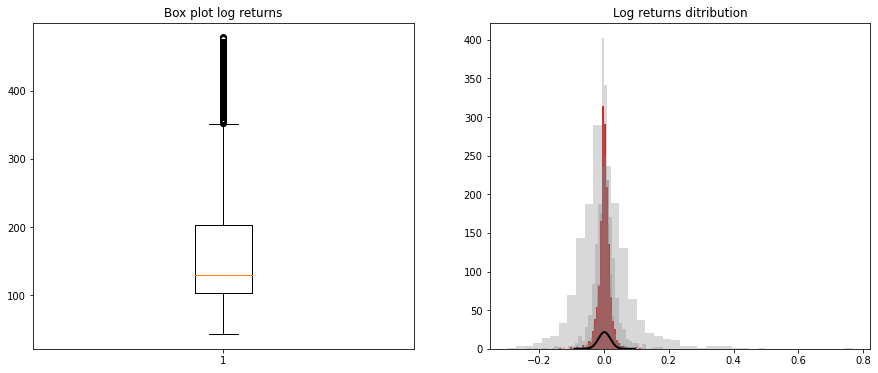

ValueError: ignored

<Figure size 1080x360 with 1 Axes>

In [27]:
import scipy.stats as st

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig.patch.set_alpha(0.2)
for i in log_rets.keys():
    if i=="AAPL":
        mu = np.mean(log_rets["AAPL"])
        sigma = np.std(log_rets["AAPL"])
        x = np.linspace(mu -5*sigma, mu +5*sigma, 1000)
        pdf = st.norm.pdf(x, mu, sigma)
        ax[1].plot(x, pdf, lw = 2, color = "black")
        ax[1].hist(log_rets[i], bins=40, color = "red")
        ax[0].boxplot(stock_prices["Close"])
        ax[0].set_title("Box plot log returns")
        ax[1].set_title("Log returns ditribution")
    else:
        ax[1].hist(log_rets[i], bins=40, color = "grey", alpha=.3)
        ax[0].set_title("Box plot log returns")
        ax[1].set_title("Log returns ditribution")


fig,ax = plt.subplots(figsize=(15,5))
fig.patch.set_alpha(0.2)
for i in log_rets.keys():
    if i=="AAPL":
        ax.plot((1+log_rets[i]).cumprod(), color="red")

    else:
        ax.plot((1+log_rets[i]).cumprod(), color="grey", alpha=.3)

ax.legend(tickers)
ax.set_title("AAPL returns over time compared to other tech stocks")
ax.text(18970, 4, ann_rets["AAPL"], size=9, color='red')

plt.show()

# Simple Regressions

In [28]:
PERCENTAGE = .995

WINDOW = 2
PREDICTION_SCOPE = 0

In [29]:
stock_prices = feature_engineering(stock_prices, SPY)

No model yet


In [30]:
stock_prices.head(20)

,Open,High,Low,Adj Close,Volume,Adj_Close2,Volume2,Low_std2,High_std2,Adj_CLose2,...,Close7,SPY,Day,Month,Year,day_year,Weekday,Upper_Shape,Lower_Shape,Close_y
Date,,,,,,,,,,,,,,,,,,,,,
2001-11-30,114.400002,114.910004,114.019997,76.894119,13680300,77.447021,15017500.0,0.721247,0.007067,0.390961,...,114.800003,114.050003,30,30,30,334,4,0.510002,0.030006,114.050003
2001-12-03,113.650002,114.080002,113.010002,76.435661,15220400,76.894119,14450350.0,0.714174,0.586900,0.324179,...,114.040001,113.370003,3,3,3,337,0,0.430000,0.360001,113.370003
2001-12-04,113.919998,115.300003,113.349998,77.730164,17239900,77.730164,16230150.0,0.240414,0.862671,0.915351,...,115.680000,115.290001,4,4,4,338,1,0.010002,0.570000,115.290001
2001-12-05,115.610001,118.000000,115.559998,79.152763,25204000,79.152763,21221950.0,1.562705,1.909186,1.005930,...,115.930000,117.400002,5,5,5,339,2,0.599998,0.050003,117.400002
2001-12-06,117.339996,117.940002,116.930000,79.112282,17972900,79.152763,21588450.0,0.968738,0.042425,0.028625,...,115.430000,117.339996,6,6,6,340,3,0.600006,0.409996,117.339996
2001-12-07,116.900002,117.089996,115.699997,78.586403,18857800,79.112282,18415350.0,0.869744,0.601045,0.371853,...,113.339996,116.559998,7,7,7,341,4,0.189995,0.860001,116.559998
2001-12-10,115.849998,116.389999,114.349998,77.116631,13862700,78.586403,16360250.0,0.954593,0.494973,1.039286,...,114.870003,114.379997,10,10,10,344,0,0.540001,0.029999,114.379997
2001-12-11,114.900002,115.720001,113.900002,76.961548,20833300,77.116631,17348000.0,0.318196,0.473760,0.109660,...,114.050003,114.150002,11,11,11,345,1,0.820000,0.250000,114.150002
2001-12-12,114.550003,114.779999,113.110001,77.049194,16171500,77.049194,18502400.0,0.558615,0.664682,0.061975,...,113.370003,114.279999,12,12,12,346,2,0.229996,1.169998,114.279999


In [31]:
train_reg, test_reg = train_test_split(stock_prices, WINDOW)
train_split_reg, validation_split_reg = train_validation_split(train_reg, PERCENTAGE)

In [32]:
print(train_reg.shape)
print(test_reg.shape)

(5224, 50)
(2, 50)


In [33]:
train_set_reg = np.array(train_split_reg)
validation_set_reg = np.array(validation_split_reg)

In [34]:
X_train_reg, y_train_reg, X_val_reg, y_val_reg = windowing(train_set_reg, validation_set_reg, WINDOW, PREDICTION_SCOPE)

In [35]:
#Reshaping the Data

X_train_reg = np.array(X_train_reg)
y_train_reg = np.array(y_train_reg)


X_val_reg = np.array(X_val_reg)
y_val_reg = np.array(y_val_reg)



X_train_reg = X_train_reg.reshape(X_train_reg.shape[0], -1)
X_val_reg = X_val_reg.reshape(X_val_reg.shape[0], -1)

In [36]:
print(y_train_reg.shape)
print(X_train_reg.shape)
print(X_val_reg.shape)
print(y_val_reg.shape)

(5195,)
(5195, 98)
(25, 98)
(25,)


In [37]:
X_test_reg = np.array(test_reg.iloc[:, :-1])
y_test_reg = np.array(test_reg.iloc[:, -1])

print(X_test_reg.shape)

(2, 49)


In [38]:
X_test_reg = X_test_reg.reshape(1, -1)

print(X_test_reg.shape)

(1, 98)


### Linear Regression

In [39]:
lr = LinearRegression()

lr.fit(X_train_reg, y_train_reg)

y_hat_lr= lr.predict(X_val_reg)

mae_lr = mean_absolute_error(y_val_reg, y_hat_lr)

print("MSE: {}".format(np.mean((y_hat_lr-y_val_reg)**2)))
print("MAE: {}".format(mae_lr))

MSE: 24.8858938013738
MAE: 4.017796212378889


### Random Forest Regressor

In [40]:
rf = RandomForestRegressor()

rf.fit(X_train_reg, y_train_reg)

y_hat_rf= rf.predict(X_val_reg)

mae_rf= mean_absolute_error(y_val_reg, y_hat_rf)

print("MSE: {}".format(np.mean((y_hat_rf-y_val_reg)**2)))
print("MAE: {}".format(mae_rf))

MSE: 36.14792185898526
MAE: 4.804089904785153


In [41]:
y_hat_rf = np.ravel(y_hat_rf)
y_hat_lr = np.ravel(y_hat_lr)
y_val_reg = np.ravel(y_val_reg)

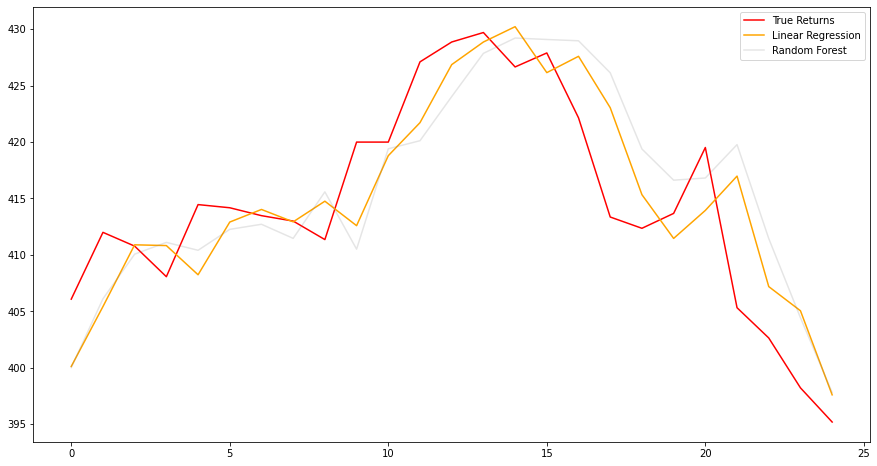

In [42]:
fig,ax = plt.subplots(figsize=(15,8))

ax.plot(y_val_reg, color="red")
ax.plot(y_hat_lr, color="orange")
ax.plot(y_hat_rf, color="grey", alpha=.2)

ax.legend(["True Returns", "Linear Regression", "Random Forest"])

In [43]:
pred_test_lr = lr.predict(X_test_reg)

For used windowed data: 2
Prediction scope for date 2022-09-03 00:00:00 / 1 days
The predicted price is 398.21$
With a spread of MAE is 4.02



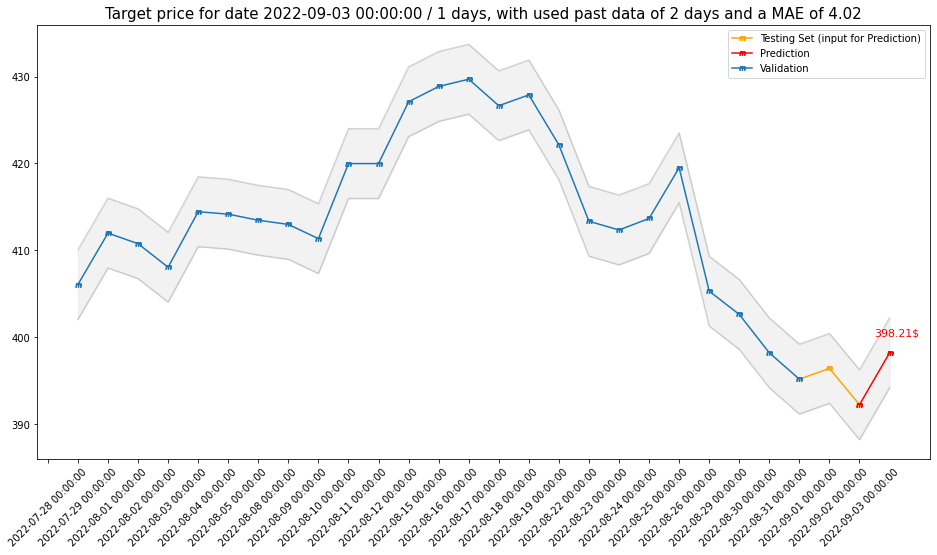

In [44]:
plotting(y_val_reg, y_test_reg, pred_test_lr, mae_lr, WINDOW, PREDICTION_SCOPE)

# XGBoost

XGBoost, is one of the most highly used supervised ML algorithms nowadays.

The algorithm uses a more optimized way to implement a tree based algorithm.

The methodology followed by this algorithm is the following. XGBoost uses a Greedy algorithm for the building of its tree, meaning it uses a simple intuitive way to optimze the algorithm. This is done by making a prediction (which acts as a threshols), before starting to evaluate the rest of the observations, which then turn into other thresholds, and so on.

This methods enables it to manage huge amount of data very quickly.

In the case of regression, it basically build up a Regression Tree through the residuals of each data point to the initial prediction. Then we split the data into portions and compare one to another and see which one is better at splitting the residuals into clusters of similar values.

For more insights into how this algorithm works, check out this video from [StatQuest](https://www.youtube.com/watch?v=OtD8wVaFm6E&t=649s)


## Feature Engineering

We will firt make the analysis forecasting 1 period ahead

In [45]:
stock_prices = yf.download("SPY", start="2001-11-30")


-----------------------------------------------------------------------------

[*********************100%***********************]  1 of 1 completed


In [46]:
PERCENTAGE = .995

WINDOW = 2
PREDICTION_SCOPE = 0

In [47]:
stock_prices = feature_engineering(stock_prices, SPY)

No model yet


In [48]:
train, test = train_test_split(stock_prices, WINDOW)


In [49]:
train_set, validation_set = train_validation_split(train, PERCENTAGE)
X_train, y_train, X_val, y_val = windowing(train_set, validation_set, WINDOW, PREDICTION_SCOPE)

In [50]:
print(train_set.shape)
print(validation_set.shape)
print(test.shape)

(5190, 50)
(27, 50)
(2, 50)


Here are some functions that pretend to ease us the work while applying the same algorithm on different period forecasts

In [51]:
train_set, validation_set = train_validation_split(train, PERCENTAGE)

In [52]:
X_train, y_train, X_val, y_val = windowing(train_set, validation_set, WINDOW, PREDICTION_SCOPE)

In [53]:
X_train = np.array(X_train)
y_train = np.array(y_train)


X_val = np.array(X_val)
y_val = np.array(y_val)

In [54]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (5188, 2, 49)
y_train shape: (5188,)
X_val shape: (25, 2, 49)
y_val shape: (25,)


In [55]:
#Reshaping the Data

X_train = np.array(X_train)
y_train = np.array(y_train)


X_val = np.array(X_val)
y_val = np.array(y_val)



X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

In [56]:
X_train.shape

(5188, 98)

[12:26:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


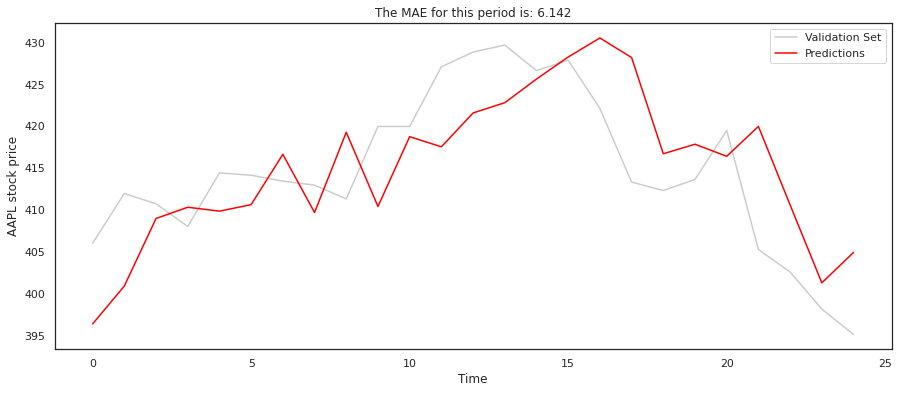

In [57]:
mae, xgb_model = xgb_model(X_train, y_train, X_val, y_val, plotting=True)

In [58]:
from xgboost import plot_importance


<Figure size 1152x1152 with 0 Axes>

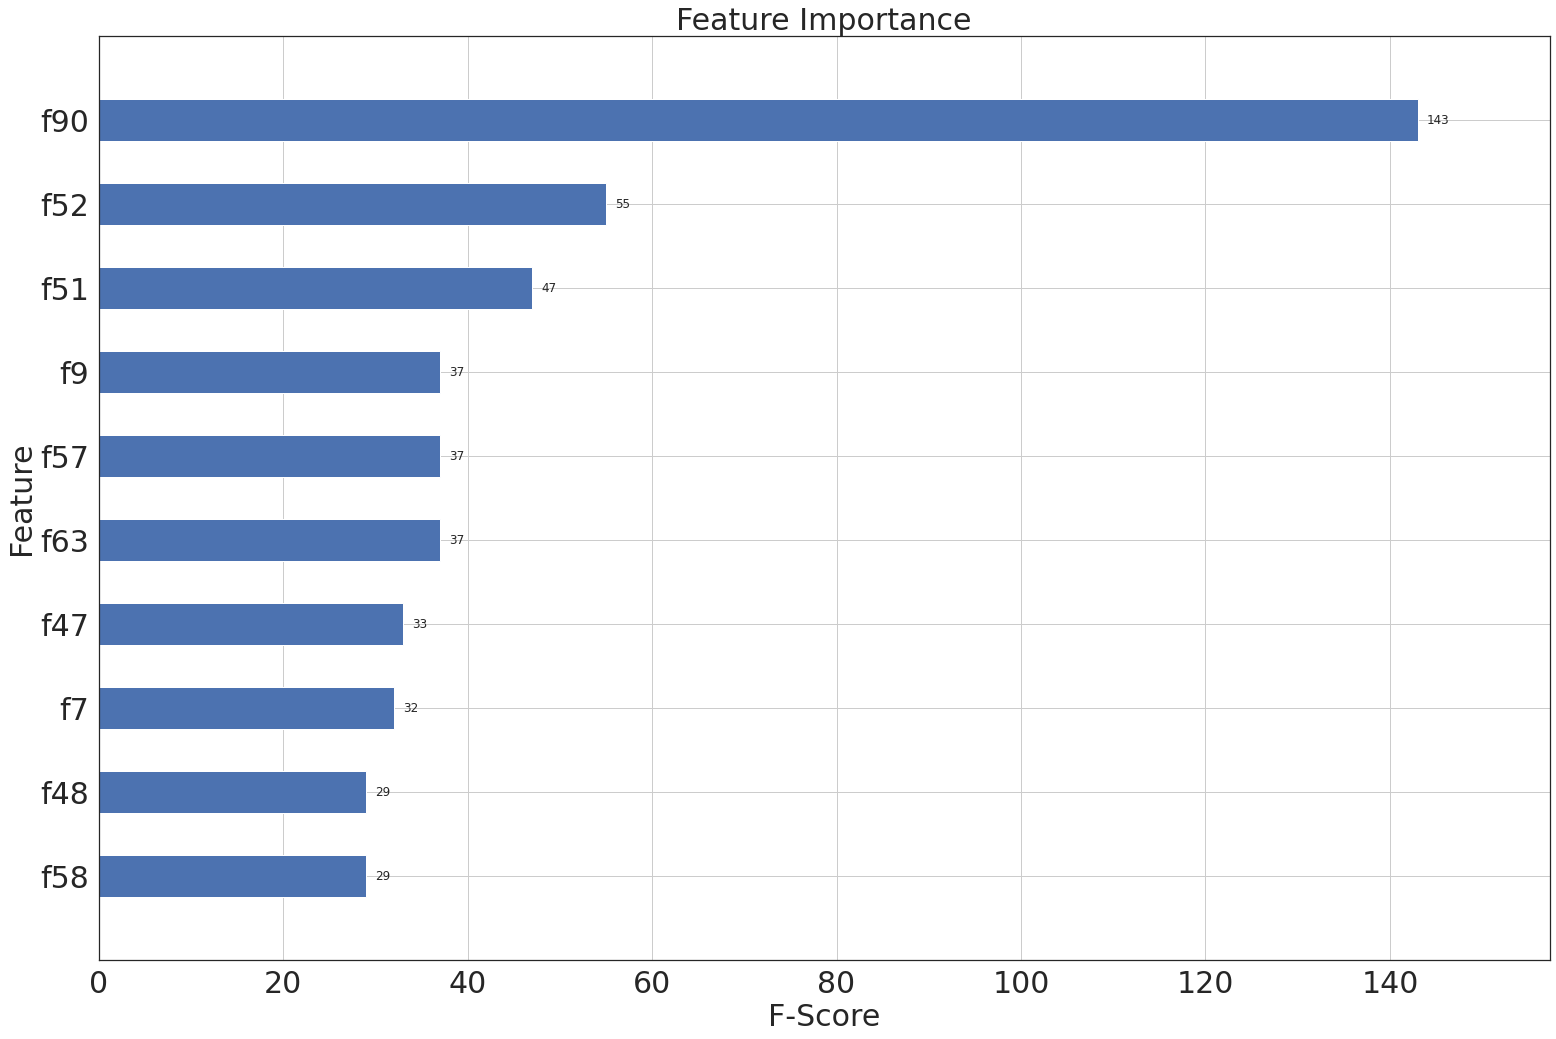

In [59]:
plt.figure(figsize=(16, 16))
fig, ax = plt.subplots(1, 1, figsize=(26, 17))

plot_importance(xgb_model,ax=ax,height=0.5, max_num_features=10)
ax.set_title("Feature Importance", size=30)
plt.xticks(size=30)
plt.yticks(size=30)
plt.ylabel("Feature", size=30)
plt.xlabel("F-Score", size=30)
plt.show()

## Add the predictions (if needed)

In [60]:
#try:
    #y_hat_train = np.expand_dims(xgb_model.predict(X_train), 1)
    #array = np.empty((stock_prices.shape[0]-y_hat_train.shape[0], 1))
    #array[:] = np.nan
    #predictions = np.concatenate((array, y_hat_train))
#except NameError:
    #print("No Model")
    
    
#new_stock_prices = feature_engineering(stock_prices, SPY, predictions=predictions)


#train, test = train_test_split(new_stock_prices, WINDOW)

#train_set, validation_set = train_validation_split(train, PERCENTAGE)
#X_train, y_train, X_val, y_val = windowing(train_set, validation_set, WINDOW, PREDICTION_SCOPE)

#Reshaping the data
#X_train = np.array(X_train)
#y_train = np.array(y_train)

#X_val = np.array(X_val)
#y_val = np.array(y_val)

#X_train = X_train.reshape(X_train.shape[0], -1)
#X_val = X_val.reshape(X_val.shape[0], -1)


#new_mae, new_xgb_model = xgb_model(X_train, y_train, X_val, y_val, plotting=True)

#print(new_mae)

## Evaluation on the Test Set

In [61]:
X_test = np.array(test.iloc[:, :-1])
y_test = np.array(test.iloc[:, -1])

print(X_test.shape)

(2, 49)


In [62]:
X_test = X_test.reshape(1, -1)

print(X_test.shape)

(1, 98)


In [63]:
#Apply the xgboost model on the Test Data

pred_test_xgb = xgb_model.predict(X_test)

For used windowed data: 2
Prediction scope for date 2022-09-03 00:00:00 / 1 days
The predicted price is 397.92$
With a spread of MAE is 6.14



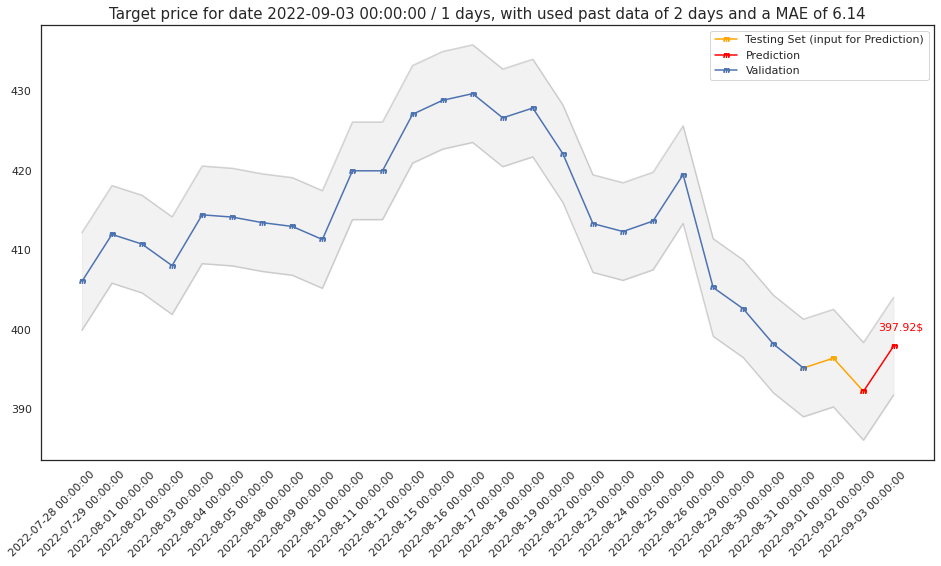


-----------------------------------------------------------------------------



In [64]:
plotting(y_val, y_test, pred_test_xgb, mae, WINDOW, PREDICTION_SCOPE)

## Saving the XGBoost parameters

In [65]:
joblib.dump(xgb_model, "XGBoost.pkl")

['XGBoost.pkl']

## MULTIPLE EVALUATIONS

In [66]:
plots = {}


for window in [1, 2, 3, 4, 5, 6, 7, 10, 20, 25, 30, 35]:
    
    for percentage in [.92, .95, .97, .98, .99, .995]:

        WINDOW = window
        pred_scope = 0
        PREDICTION_SCOPE = pred_scope
        PERCENTAGE = percentage

        train = stock_prices.iloc[:int(len(stock_prices))-WINDOW]
        test = stock_prices.iloc[-WINDOW:]
        
        train_set, validation_set = train_validation_split(train, PERCENTAGE)

        X_train, y_train, X_val, y_val = windowing(train_set, validation_set, WINDOW, PREDICTION_SCOPE)

        X_train = np.array(X_train)
        y_train = np.array(y_train)

        X_val = np.array(X_val)
        y_val = np.array(y_val)

        X_test = np.array(test.iloc[:, :-1])
        y_test = np.array(test.iloc[:, -1])

        X_train = X_train.reshape(X_train.shape[0], -1)
        try:
            X_val = X_val.reshape(X_val.shape[0], -1)
            X_test = X_test.reshape(1, -1)
        except ValueError:
            break

        xgb_model = xgb.XGBRegressor(gamma=1)
        xgb_model.fit(X_train, y_train)

        pred_val = xgb_model.predict(X_val)

        mae = mean_absolute_error(y_val, pred_val)

        pred_test = xgb_model.predict(X_test)
        plotii= [y_test[-1], pred_test]

        plots[str(window)+str(pred_scope)] = [y_val, y_test, pred_test, mae, WINDOW, PREDICTION_SCOPE, PERCENTAGE]
    

[12:27:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:27:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:27:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:27:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:27:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:27:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:27:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:27:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [67]:
print()
print(plots["20"])
print("-----------------------------------------------------------------------------------------------------------------")
print(plots["10"])


[array([406.07000732, 411.98999023, 410.76998901, 408.05999756,
       414.45001221, 414.17001343, 413.47000122, 412.98999023,
       411.3500061 , 419.98999023, 419.98999023, 427.1000061 ,
       428.85998535, 429.70001221, 426.6499939 , 427.89001465,
       422.14001465, 413.3500061 , 412.3500061 , 413.67001343,
       419.51000977, 405.30999756, 402.63000488, 398.20999146,
       395.17999268]), array([396.42001343, 392.23999023]), array([397.7927], dtype=float32), 5.918912353515625, 2, 0, 0.995]
-----------------------------------------------------------------------------------------------------------------
[array([406.07000732, 411.98999023, 410.76998901, 408.05999756,
       414.45001221, 414.17001343, 413.47000122, 412.98999023,
       411.3500061 , 419.98999023, 419.98999023, 427.1000061 ,
       428.85998535, 429.70001221, 426.6499939 , 427.89001465,
       422.14001465, 413.3500061 , 412.3500061 , 413.67001343,
       419.51000977, 405.30999756, 402.63000488, 398.20999146,
 

In [68]:
window_optimization(plots)

([[array([411.98999023, 410.76998901, 408.05999756, 414.45001221,
          414.17001343, 413.47000122]),
   array([412.98999023, 411.3500061 , 419.98999023, 419.98999023,
          427.1000061 , 428.85998535, 429.70001221, 426.6499939 ,
          427.89001465, 422.14001465, 413.3500061 , 412.3500061 ,
          413.67001343, 419.51000977, 405.30999756, 402.63000488,
          398.20999146, 395.17999268, 396.42001343, 392.23999023]),
   array([394.74957], dtype=float32),
   3.6641133626302085,
   20,
   0,
   0.995]],
 ['200'])

For used windowed data: 6
Prediction scope for date 2022-09-03 00:00:00 / 1 days
The predicted price is 398.54$
With a spread of MAE is 5.0



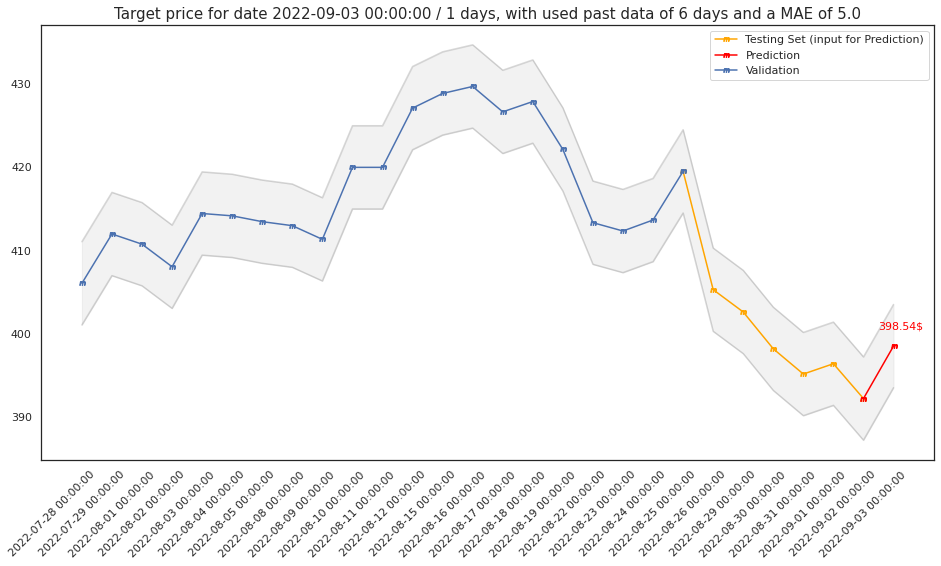


-----------------------------------------------------------------------------

For used windowed data: 7
Prediction scope for date 2022-09-03 00:00:00 / 1 days
The predicted price is 398.92$
With a spread of MAE is 5.16



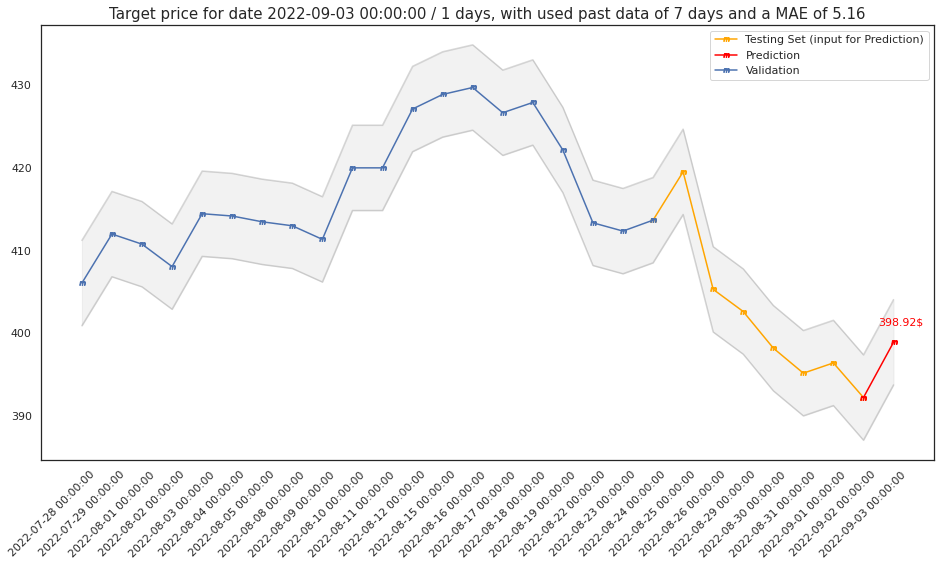


-----------------------------------------------------------------------------

For used windowed data: 10
Prediction scope for date 2022-09-03 00:00:00 / 1 days
The predicted price is 394.12$
With a spread of MAE is 5.25



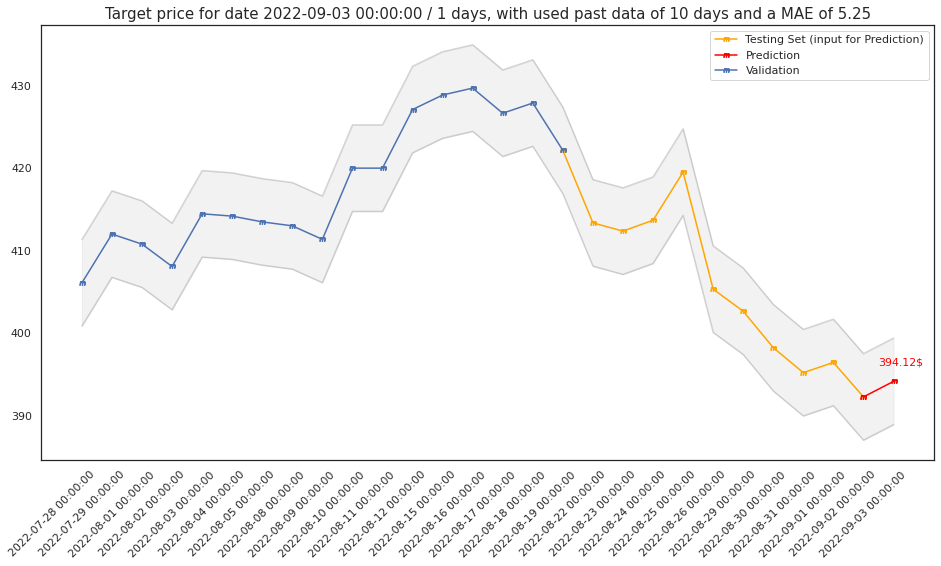


-----------------------------------------------------------------------------

For used windowed data: 20
Prediction scope for date 2022-09-03 00:00:00 / 1 days
The predicted price is 394.75$
With a spread of MAE is 3.66



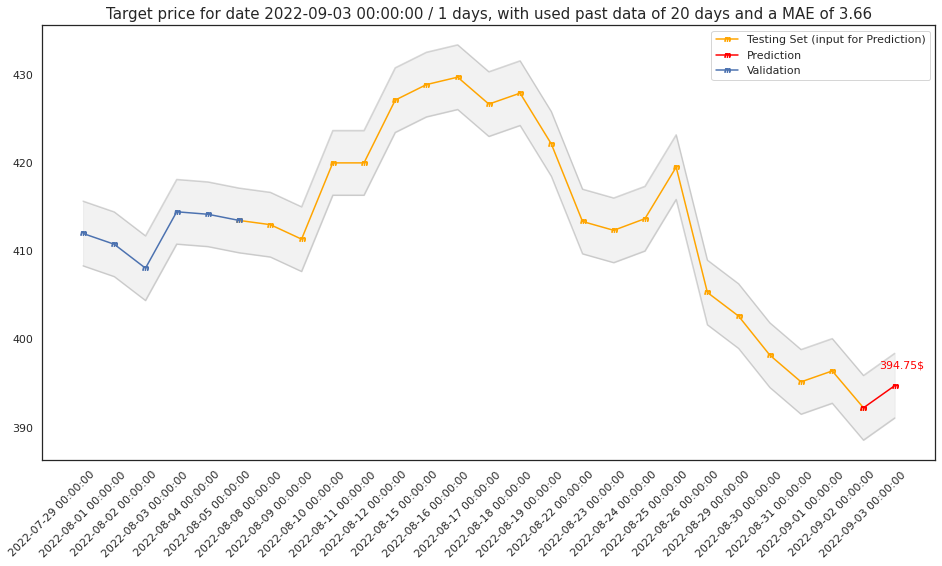


-----------------------------------------------------------------------------



In [69]:
for key in list(plots.keys())[5:9]:
    plotting(plots[key][0], plots[key][1], plots[key][2], plots[key][3], plots[key][4], plots[key][5])

# LSTM


Long Short Term Memory or LSTM is a type of Recurrent Neural Network, which instead fo only processing the information they recieve from the previous neuron and apply the activation function from scratch, they actually divide the neuron into three main parts from which to set up the input from the next layer of neurons: Learn, Unlearn and Retain gate.

The idea behind this method is to ensure that you are using the information given from previous data and the data returned from a neural that is in the same layer, to get the input for the next nuron.

This is specially usefull, when you are relying on the temporal distribution of the data, i.e. text, time series mainly.

In this work we will see how the LSTM is used for predicting the next period from Apple stock. Through hyperparameter tuning there was a need to define, similar to normal RNN, the input and hidden layer size, the batch_size, number of epochs and the rolling window size for the analysis.

The data ranging from 2001 till now, gained from the Yahoo Finance API, got splitted into a train, validation and test set to see how the model performed on different distributions. After that, the test set was settled to be the last width of the input data in order to predict the next period.

The parameters are showed below.

In [70]:
#Parameters for the LSTM

PERCENTAGE = .98 #Split train/val and test set

CALLBACK = .031 #Used to stop training the Network when the MAE from the validation set reached a perormance below 3.1%
BATCH_SIZE = 20 #Number of samples that will be propagated through the network. I chose almost a trading month
EPOCH = 50 #Settled to train the model
WINDOW_LSTM = 2 #The window used for the input data
PREDICTION_SCOPE = 0 #How many period to predict, being 0=1

In [71]:
train_lstm, test_lstm = train_test_split(stock_prices, WINDOW_LSTM)

In [72]:
train_split_lstm, validation_split_lstm = train_validation_split(train_lstm, PERCENTAGE)

## Rescaling to train the LSTM

In [73]:
scaler = MinMaxScaler()
scaler.fit(train_split_lstm)

MinMaxScaler()

In [74]:
print(train_split_lstm.shape)
print(validation_split_lstm.shape)

(5112, 50)
(105, 50)


In [75]:
train_split_lstm = np.array(train_split_lstm)
validation_split_lstm = np.array(validation_split_lstm)

In [76]:
train_scale_lstm = scaler.transform(train_split_lstm)
val_scale_lstm = scaler.transform(validation_split_lstm)
test_scale_lstm = scaler.transform(test_lstm)

In [77]:
print(train_scale_lstm.shape)
print(val_scale_lstm.shape)
print(test_scale_lstm.shape)

(5112, 50)
(105, 50)
(2, 50)


In [78]:
X_train_lstm, y_train_lstm, X_val_lstm, y_val_lstm = windowing(train_scale_lstm, val_scale_lstm, WINDOW_LSTM, PREDICTION_SCOPE)

In [79]:
X_train_lstm = np.array(X_train_lstm)
y_train_lstm = np.array(y_train_lstm)

X_val_lstm = np.array(X_val_lstm)
y_val_lstm = np.array(y_val_lstm)

X_test_lstm = np.array(test_scale_lstm[:, :-1])
y_test_lstm = np.array(test_scale_lstm[:, -1])

In [80]:
print(X_train_lstm.shape)
print(X_val_lstm.shape)
print(X_test_lstm.shape)

(5110, 2, 49)
(103, 2, 49)
(2, 49)


Epoch 1/30
341/341 [==============================] - ETA: 0s - loss: 0.0012 - mae: 0.0210
 Accuracy % so cancelling training
341/341 [==============================] - 6s 6ms/step - loss: 0.0012 - mae: 0.0210 - val_loss: 3.5311e-04 - val_mae: 0.0195


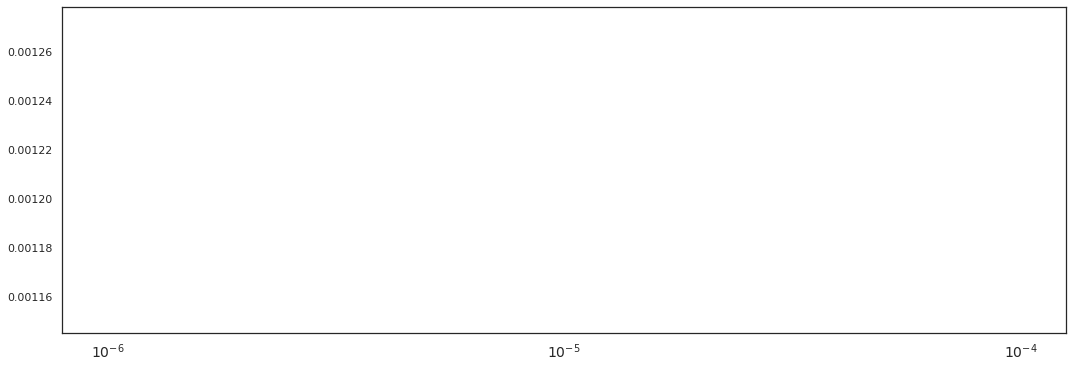

In [81]:
model_lstm = lstm_model(X_train_lstm, y_train_lstm, X_val_lstm, y_val_lstm, 30, 15,CALLBACK, plotting=True)

In [82]:
y_hat_lstm = model_lstm.predict(X_val_lstm)
y_hat_train_lstm = model_lstm.predict(X_train_lstm)

In [83]:
mae_lstm = mean_absolute_error(y_hat_lstm, y_hat_lstm)

In [84]:
real_val, pred_val = inverse_transformation(X_val_lstm, y_val_lstm, y_hat_lstm)

In [85]:
mae_lstm = mean_absolute_error(real_val.iloc[:, 49], pred_val.iloc[:, 49])

In [86]:
real_val.tail()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
98,412.899994,415.420013,411.769989,412.350006,49105200.0,413.350006,63400400.0,0.445481,1.279862,0.707107,...,427.100006,412.350006,23.0,23.0,23.0,235.0,1.0,2.520020,0.580017,419.510010
99,412.109985,415.109985,411.390015,413.670013,49177800.0,413.670013,49141500.0,0.268682,0.219223,0.933386,...,428.859985,413.670013,24.0,24.0,24.0,236.0,2.0,1.439972,0.719971,405.309998
100,415.239990,419.559998,414.089996,419.510010,50942300.0,419.510010,50060050.0,1.909175,3.146634,4.129501,...,429.700012,419.510010,25.0,25.0,25.0,237.0,3.0,0.049988,1.149994,402.630005
101,419.390015,419.959991,405.250000,405.309998,103087000.0,419.510010,77014650.0,6.250821,0.282838,10.040925,...,426.649994,405.309998,26.0,26.0,26.0,238.0,4.0,0.569977,0.059998,398.209991
102,402.200012,405.839996,401.200012,402.630005,65370800.0,405.309998,84228900.0,2.863774,9.984344,1.895041,...,427.890015,402.630005,29.0,29.0,29.0,241.0,0.0,3.209991,1.000000,395.179993


Text(0.5, 1.0, 'MAE for this period: 8.0')

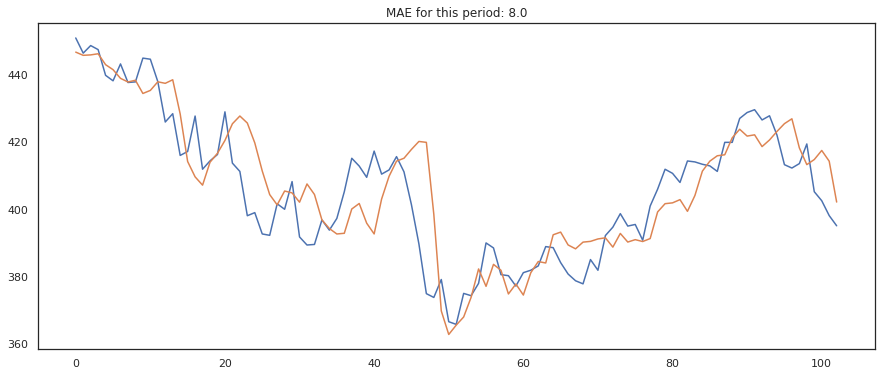

In [87]:
plt.figure(figsize=(15, 6))

plt.plot(real_val.iloc[:, 49])
plt.plot(pred_val.iloc[:, 49])

plt.title(f"MAE for this period: {round(mae_lstm, 2)}")

In [88]:
real_train, pred_train = inverse_transformation(X_train_lstm, y_train_lstm, y_hat_train_lstm)

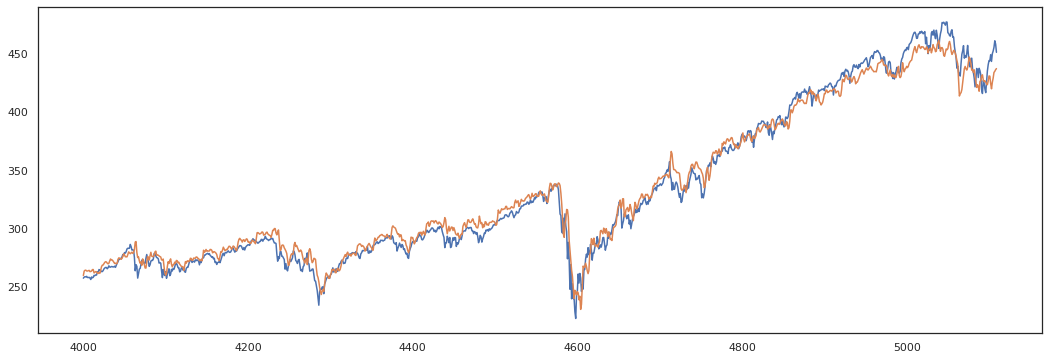

In [89]:
plt.figure(figsize=(18, 6))

plt.plot(real_train.iloc[4000:, 49])
plt.plot(pred_train.iloc[4000:, 49])

## Prediction

In [90]:
X_test_formula = X_test_lstm.reshape(X_test_lstm.shape[0], 1, X_test_lstm.shape[1])

In [91]:
X_test_formula.shape

(2, 1, 49)

In [92]:
X_test_lstm = X_test_formula.reshape(1, X_test_formula.shape[0], X_test_formula.shape[2])

In [93]:
X_test_lstm.shape

(1, 2, 49)

In [94]:
y_hat_test_lstm = model_lstm.predict(X_test_lstm)

In [95]:
real_test, pred_test = inverse_transformation(X_test_lstm, y_test_lstm, y_hat_test_lstm)

In [96]:
y_val_lstm = np.array(real_val.iloc[-30:, 49])
y_test_lstm = np.array(real_test.iloc[:, 49])
pred_test = np.array(pred_test.iloc[-1:, 49])
mae_lstm = mean_absolute_error(real_val.iloc[:, 49], pred_val.iloc[:, 49])

For used windowed data: 2
Prediction scope for date 2022-09-03 00:00:00 / 1 days
The predicted price is 403.46$
With a spread of MAE is 8.0



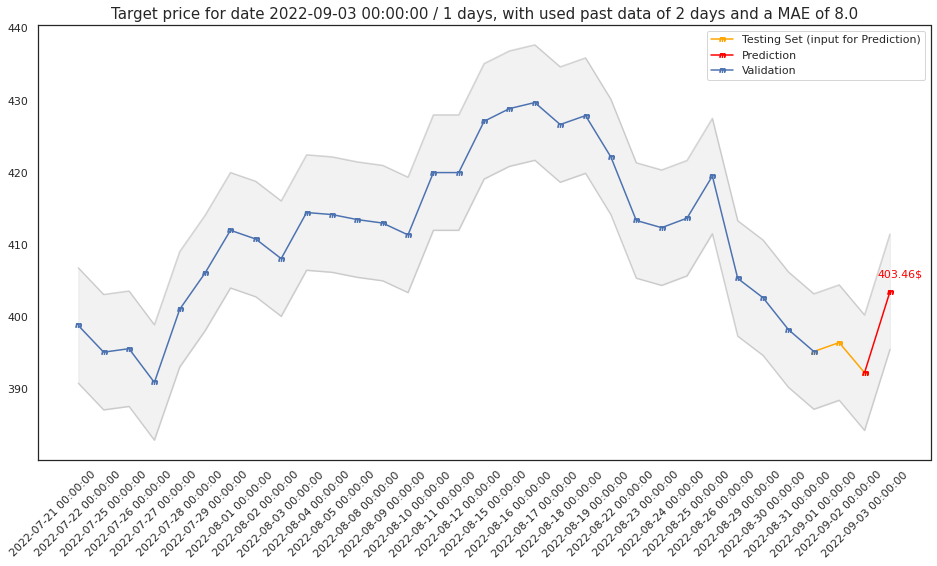


-----------------------------------------------------------------------------



In [97]:
plotting(y_val_lstm, y_test_lstm, pred_test, mae_lstm, WINDOW_LSTM, PREDICTION_SCOPE)

## Saving the Model

In [98]:
#model.save('./SVM')

In [99]:
#lstm_model = tf.keras.models.load_model("SVM")

# COMBINATION XGBoost-LSTM


In order to get the most out of the two models, good practice is to combine those two and apply a higher weight on the model which got a lower loss function (mean absolute error).

In our case we saw that the MAE of the XGBoost was lower than the one from the LSTM, therefore we will gave a higher weight on the predictions returned from the XGBoost model.

In [100]:
mae_xgboost = mae

In [101]:
xgboost_model = joblib.load("XGBoost.pkl")

[12:44:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [102]:
pred_test

array([403.46336226])

In [103]:
pred_test_xgb

array([397.92108], dtype=float32)

In [104]:
scope = predictions(mae_lstm, mae_xgboost, pred_test_xgb, pred_test)

In [105]:
avg_mae = (mae_lstm + mae_xgboost)/2

In [106]:
plotting(y_val, y_test, scope, avg_mae, WINDOW, PREDICTION_SCOPE)

IndexError: ignored

In [122]:
from pandas.core.indexes.datetimes import DatetimeIndex
mdf = pd.DataFrame([pred_test_xgb], columns = ['xgb'])
mdf['LSTM'] = pred_test
mdf['LR'] = pred_test_lr
mdf.index = pd.to_datetime(today)
mdf

NameError: ignored

In [128]:
import datetime as dt     
date = dt.date.today

AttributeError: ignored

In [145]:
mdf.index =  [pd.to_datetime("today").strftime("%m/%d/%Y")]

mdf

,xgb,LSTM,LR,today
09/06/2022,397.921082,403.463362,398.210006,09/06/2022
